In [1]:
from pathlib import Path, WindowsPath, PosixPath
# SETTINGS ------------------------------------------------------------------------
CONFIG = {
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_final"), 
}
for key in CONFIG: globals()[key] = CONFIG[key];

In [2]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
# ----------------------------------------------------------------------------------------
import sys, os
if 'ROOT' not in globals(): global ROOT; ROOT = Path('../..').resolve()
print(f"{'-'*60}\nDirectories:\n  {ROOT}:\t\t\t{', '.join([_.name for _ in ROOT.glob('*/')])}")
sys.path.append(os.path.abspath(ROOT))
from data import get_data_path  # paths set in "data/__init__.py"
global DATA_PATH
DATA_PATH = get_data_path()
print(f"  {DATA_PATH}:\t\t\t{', '.join([_.name for _ in DATA_PATH.glob('*/')])}")

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
from src.utils.data_utils import *
from src.utils.Trainer import *
from VehModel import CreateVehicle
from Mot_Pwr import estimate_mot_pwr

# NOTEBOOK / SCRIPT SETTINGS -------------------------------------------------------------
# ----------------------------------------------------------------------------------------
global IS_NOTEBOOK
IS_NOTEBOOK = False
try:    # if running in IPython
    shell = get_ipython().__class__.__name__ # type: ignore 
    from IPython.display import display, HTML, Javascript, clear_output
    from IPython.core.magic import register_cell_magic
    @register_cell_magic    # cells can be skipped by using '%%skip' in the first line
    def skip(line, cell): return
    from tqdm.notebook import tqdm as tqdm_nb
    IS_NOTEBOOK = True
    print(f"{'-'*60}\nRunning in notebook mode")
except (NameError, ImportError):    # if running in script
    from tqdm import tqdm as tqdm
    from tabulate import tabulate
    print(f"{'-'*60}\nRunning in script mode")
    
# GENERAL MODULE IMPORTS -----------------------------------------------------------------
# ----------------------------------------------------------------------------------------
import math, time, random, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import pyarrow.parquet as pq
from copy import deepcopy
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score
from scipy.signal import savgol_filter

------------------------------------------------------------
Directories:
  C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-eR-PINN:			.git, archive, data, project, ref, src, test
  C:\Users\SIEGLEW\OneDrive - Daimler Truck\MA\Code\MA-Data:			OLD, processed, TripSequences
------------------------------------------------------------
Running in notebook mode


In [3]:
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pickle_folder = Path(DATA_PATH, "TripSequences", "trips_processed_pickles") # Processed trip files

all_files = [Path(input_folder, f).name for f in os.listdir(input_folder) if f.endswith(".parquet")]
print(f"{'-'*60}\nTotal Files:\t{len(all_files)}")

------------------------------------------------------------
Total Files:	18629


In [4]:
samples = random.sample(all_files,10)

V14_T1354
V10_T30
V16_T993
V16_T2149
V16_T1507
V14_T2188
V14_T109
V1_T494
V13_T63
V17_T533


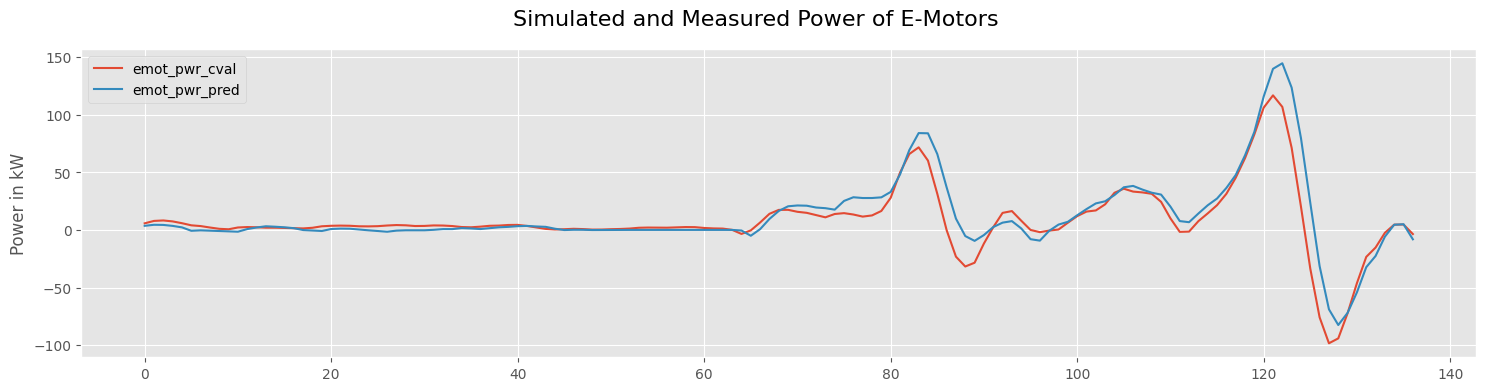

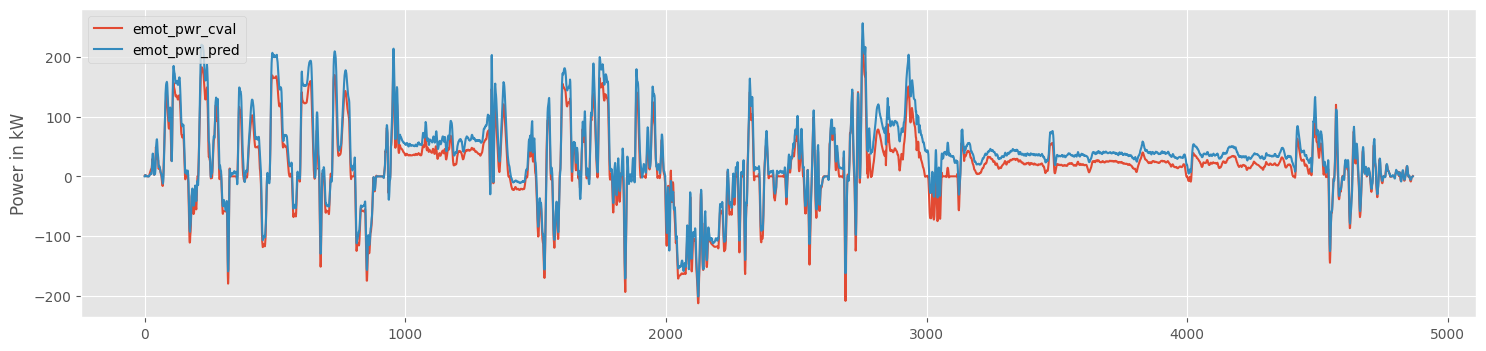

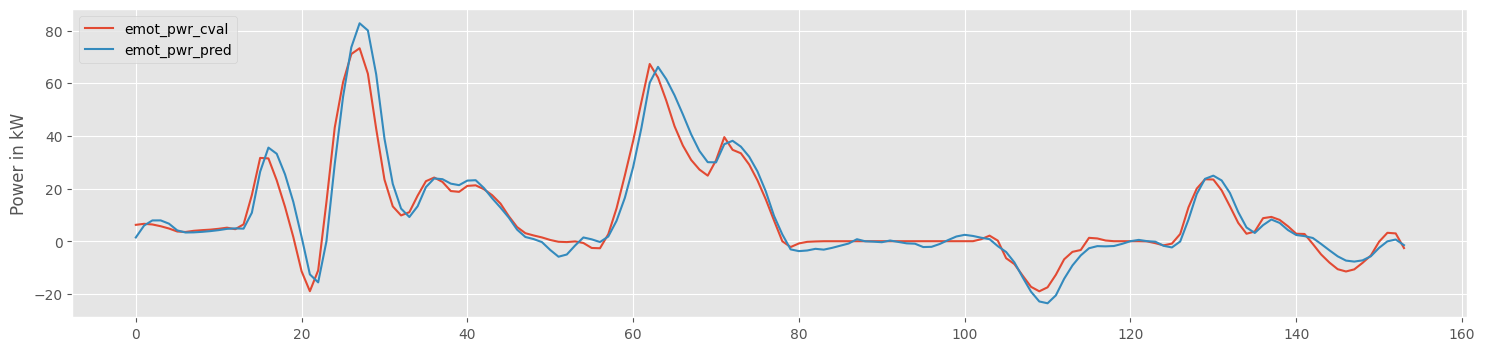

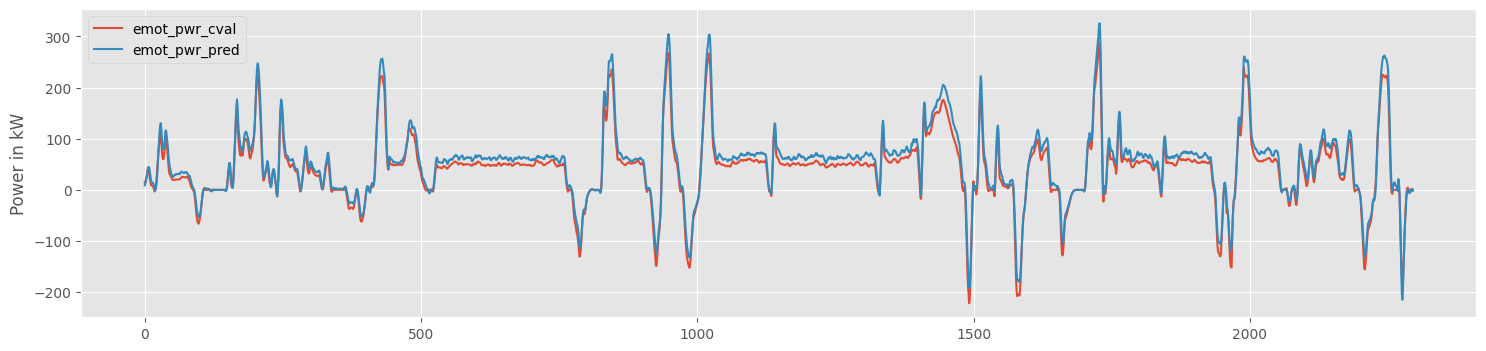

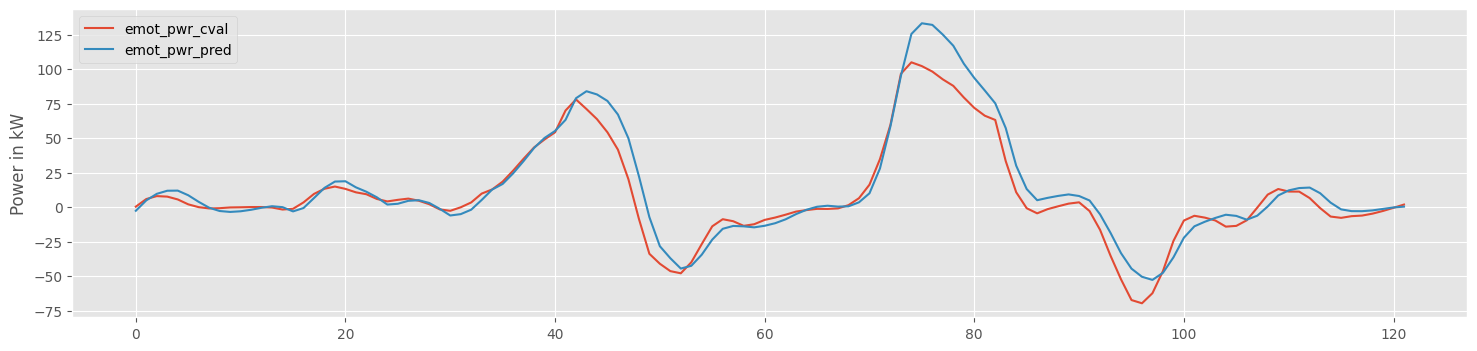

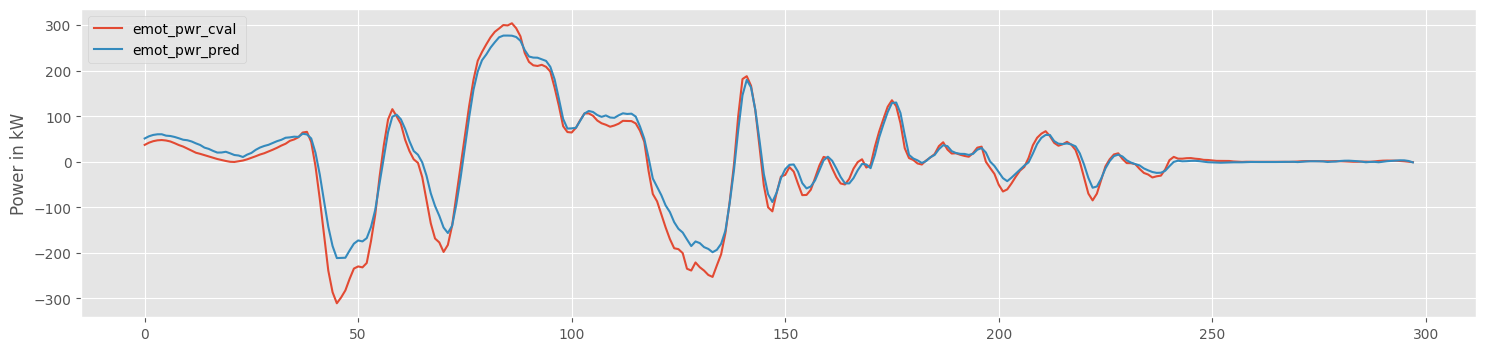

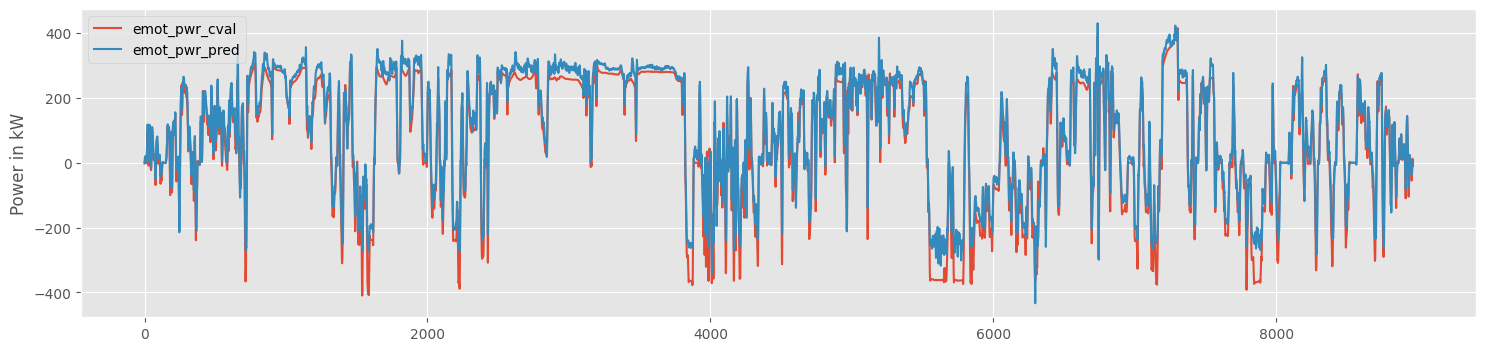

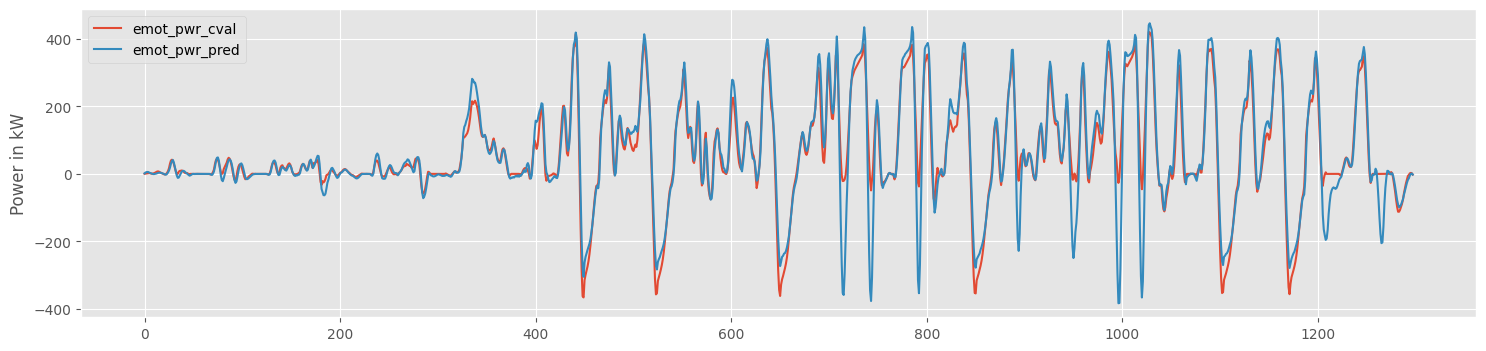

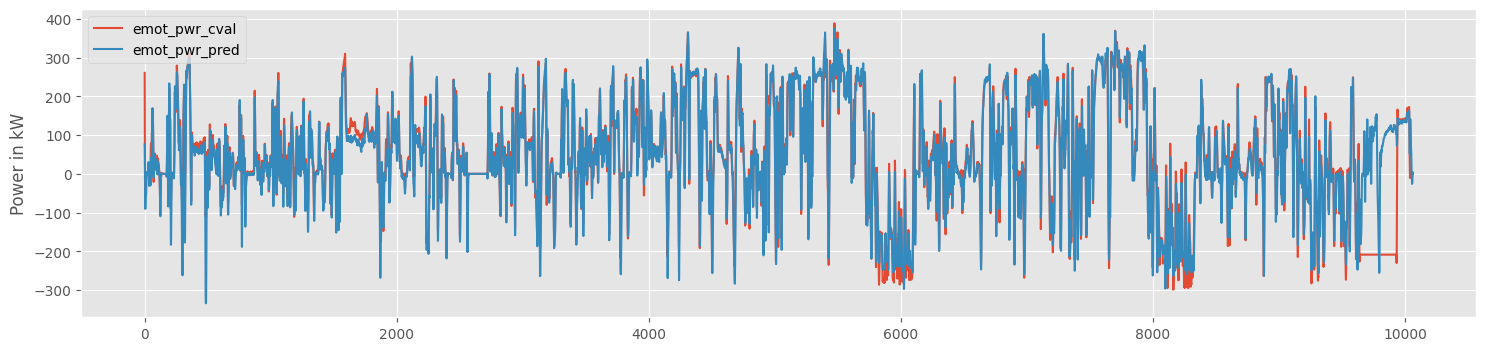

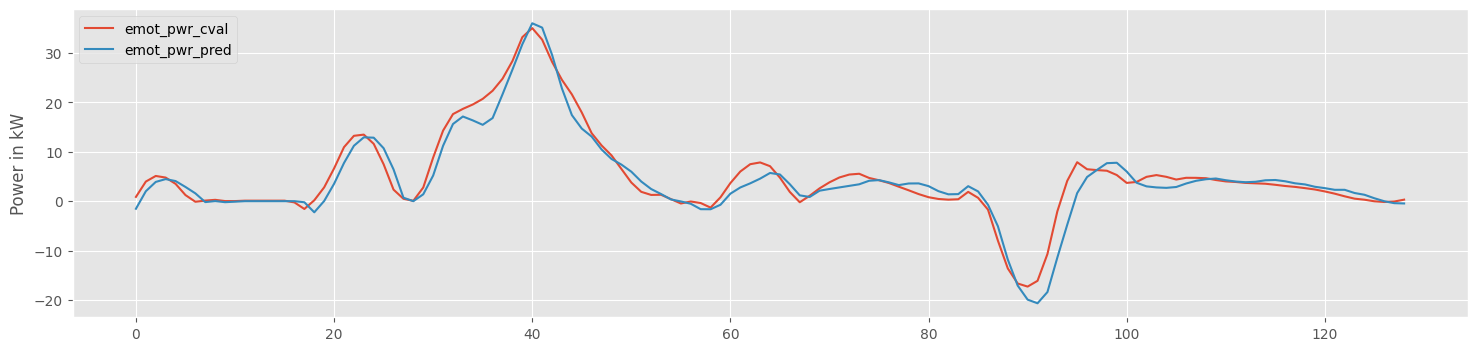

In [5]:
for f in samples:

    file_code = f.strip(".parquet")
    print(file_code)

    with open(Path(pickle_folder, f'{file_code}.pickle'), 'rb') as handle:
        T,C,V_prm = pickle.load(handle) 

    emot_pwr_true = pd.read_parquet(input_folder / f, engine='pyarrow', columns = ["emot_pwr_cval"])

    emot_pwr_pred = estimate_mot_pwr(T.speed, 
                        T.accel, 
                        T.alt, 
                        T.road_grad, 
                        T.amb_temp, 
                        T.vehweight, 
                        V_prm["c_w_a"], 
                        V_prm["tire_roll_res_coeff"], 
                        rot_inertia = 0, 
                        eta_mech = 0.97,
                        eta_mot = 0.88
                        )

    fig , axs = plt.subplots(1, sharex=True,figsize=(18, 4))
    if f == samples[0]: plt.suptitle('Simulated and Measured Power of E-Motors', fontsize='16')
    axs.set_ylabel('Power in kW', fontsize='12')
    axs.plot(savgol_filter(emot_pwr_true["emot_pwr_cval"], 10, 3), label="emot_pwr_cval")
    axs.plot(savgol_filter(emot_pwr_pred, 10, 3), label="emot_pwr_pred")
    #axs.plot(df.emot_pwr_cval - P_mot, label="diff")
    axs.legend(loc="upper left")
    #axs.set_xlim([24000,25000])
